In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 50)

# Use this to see how much memory the dataframes use
from sys import getsizeof

from vivarium_research_prl.utils import sizemb
from vivarium_research_prl import datatypes
from vivarium_research_prl.noise import corruption, fake_names, noisify
from vivarium_research_prl.find_kids import datasets, noisify_data

!date
!whoami
!uname -a
!pwd

Fri 17 Mar 2023 02:21:36 PM PDT
ndbs
Linux int-slurm-sarchive-p0004 5.4.0-135-generic #152-Ubuntu SMP Wed Nov 23 20:19:22 UTC 2022 x86_64 x86_64 x86_64 GNU/Linux
/mnt/share/code/ndbs/vivarium_research_prl/model_validation


In [2]:
%load_ext autoreload
%autoreload 2

# Find data

Looks like the same run we were looking at before, but post-processing has been fixed to keep year of observation in the data.

```
/mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/vv_tax_observers/united_states_of_america/2023_03_06_12_42_55/final_results/2023_03_14_16_41_22
```

## Expected columns from documentation:

https://vivarium-research.readthedocs.io/en/latest/models/concept_models/vivarium_census_synthdata/concept_model.html#w2-and-1099-forms

Unique simulant ID (for PRL tracking)

First name

Middle initial

Last name

Age

DOB (stored as a string in MM/DD/YYYY format)

Mailing Address Street Number (blank for PO boxes)

Mailing Address Street Name (blank for PO boxes)

Mailing Address Unit (blank for PO boxes)

Mailing Address PO Box (blank for not PO boxes)

Mailing Address City

Mailing Address State

Mailing Address ZIP Code

Social Security Number

Wages (income from this job)

Employer ID

Employer Name

Employer Address

Employer ZIP Code

Type of Tax Form (W2 or 1099)

In [4]:
project_output_dir = \
    '/mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop'
output_subdir = (
    'results/vv_tax_observers'
    '/united_states_of_america/2023_03_06_12_42_55'
    '/final_results/2023_03_14_16_41_22'
)
output_dir = f'{project_output_dir}/{output_subdir}'

!ls -halt $output_dir

total 14G
drwxrwsr-x  2 albrja IHME-Simulationscience 4.0K Mar 15 10:01 .
-rw-r--r--  1 albrja IHME-Simulationscience  59M Mar 15 10:01 wic_observer.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 1.5G Mar 15 10:01 tax_dependents_observer.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 6.8G Mar 15 09:57 tax_w2_observer.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 4.1G Mar 15 09:56 tax_1040_observer.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 192M Mar 15 09:48 social_security_observer.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience  35M Mar 15 09:36 household_survey_observer_cps.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 6.7M Mar 15 09:36 household_survey_observer_acs.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 638M Mar 15 09:36 decennial_census_observer.csv.bz2
drwxrwsr-x 12 albrja IHME-Simulationscience 5.5K Mar 14 20:25 ..


In [5]:
%%time
print(output_dir)
w2 = pd.read_csv(f'{output_dir}/tax_w2_observer.csv.bz2', nrows=1000)
w2

/mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/vv_tax_observers/united_states_of_america/2023_03_06_12_42_55/final_results/2023_03_14_16_41_22
CPU times: user 36.6 ms, sys: 4.26 ms, total: 40.8 ms
Wall time: 54.3 ms


,ssn,mailing_address_street_number,employer_street_number,middle_initial,employer_id,is_w2,mailing_address_state,mailing_address_unit_number,employer_name,simulant_id,...,last_name,first_name,mailing_address_city,age,employer_state,tax_year,mailing_address_po_box,mailing_address_zipcode,income,employer_unit_number
0,673-04-9302,7136,NaN,M,1498550,True,TX,NaN,Quality Discount Funerals,2284_0,...,Ticas,Michael,sour lake,38.831680,OH,2020,0,77566.0,26807.917509,NaN
1,471-07-7760,428,309,L,213995,True,MN,NaN,Matsuyama Gerald W Bautsch MS NCC,2284_8,...,Kohtz,Megan,prior lk,32.638476,MI,2020,0,56073.0,15902.739207,NaN
2,471-07-7760,428,1960,L,1250255,True,MN,NaN,Venus Nails & Joint,2284_8,...,Kohtz,Megan,prior lk,32.638476,WA,2020,0,56073.0,1993.518032,unit 170
3,532-81-3677,427,e,D,650079,True,NJ,NaN,American Laser & Eyeglasses,2284_10,...,Reiter,Keith,brielle,60.912309,IL,2020,0,8721.0,158485.553363,NaN
4,837-44-4483,427,NaN,M,919451,True,NJ,NaN,Auto Repair Expert Collision Center,2284_11,...,Reiter,Pamela,brielle,54.332492,SC,2020,0,8721.0,4168.897324,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,380-14-4060,644,1531,M,901046,True,PA,NaN,E Teen Parent Care,2284_1242,...,Jacobson,James,philadelphia,66.179743,CA,2020,0,18201.0,54062.795556,NaN
996,241-83-9137,644,3200,M,169446,True,PA,NaN,Sky Vista Elementary Sch,2284_1243,...,Jacobson,Jana,philadelphia,42.706691,FL,2020,0,18201.0,54178.336214,NaN
997,241-83-9137,644,7285,M,1639576,True,PA,NaN,Broadneck Home Depot USA,2284_1243,...,Jacobson,Jana,philadelphia,42.706691,AL,2020,0,18201.0,11067.680205,NaN
998,382-64-6532,644,2214,J,612851,True,PA,NaN,Elmsford Chiropractic Center,2284_1244,...,Casey,Arthur,philadelphia,49.636575,MD,2020,0,18201.0,54107.674563,NaN


In [6]:
w2.dtypes

ssn                               object
mailing_address_street_number     object
employer_street_number            object
middle_initial                    object
employer_id                        int64
is_w2                               bool
mailing_address_state             object
mailing_address_unit_number       object
employer_name                     object
simulant_id                       object
employer_street_name              object
date_of_birth                     object
employer_city                     object
mailing_address_street_name       object
employer_zipcode                 float64
last_name                         object
first_name                        object
mailing_address_city              object
age                              float64
employer_state                    object
tax_year                           int64
mailing_address_po_box             int64
mailing_address_zipcode          float64
income                           float64
employer_unit_nu

In [10]:
w2.tax_year.value_counts()

2020    1000
Name: tax_year, dtype: int64

# Load in full W2 data, with datatype conversions

In [12]:
print(output_dir)
%time df_w2 = datatypes.load_csv_data(\
    f'{output_dir}/tax_w2_observer.csv.bz2',\
    convert_str_ids=True,\
    nrows=None,\
)
%time print('\n', sizemb(df_w2), 'MB')
df_w2

/mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/vv_tax_observers/united_states_of_america/2023_03_06_12_42_55/final_results/2023_03_14_16_41_22
CPU times: user 41min 46s, sys: 1min 42s, total: 43min 29s
Wall time: 43min 33s

 8398.858271 MB
CPU times: user 1.87 s, sys: 1.02 s, total: 2.89 s
Wall time: 2.89 s


,ssn,mailing_address_street_number,employer_street_number,middle_initial,employer_id,is_w2,mailing_address_state,mailing_address_unit_number,employer_name,simulant_id,...,last_name,first_name,mailing_address_city,age,employer_state,tax_year,mailing_address_po_box,mailing_address_zipcode,income,employer_unit_number
0,673049302,7136,NaN,M,1498550,True,TX,NaN,Quality Discount Funerals,2284000000000,...,Ticas,Michael,sour lake,38.831680,OH,2020,0,77566.0,26807.917969,NaN
1,471077760,428,309,L,213995,True,MN,NaN,Matsuyama Gerald W Bautsch MS NCC,2284000000008,...,Kohtz,Megan,prior lk,32.638477,MI,2020,0,56073.0,15902.739258,NaN
2,471077760,428,1960,L,1250255,True,MN,NaN,Venus Nails & Joint,2284000000008,...,Kohtz,Megan,prior lk,32.638477,WA,2020,0,56073.0,1993.518066,unit 170
3,532813677,427,e,D,650079,True,NJ,NaN,American Laser & Eyeglasses,2284000000010,...,Reiter,Keith,brielle,60.912308,IL,2020,0,8721.0,158485.546875,NaN
4,837444483,427,NaN,M,919451,True,NJ,NaN,Auto Repair Expert Collision Center,2284000000011,...,Reiter,Pamela,brielle,54.332493,SC,2020,0,8721.0,4168.897461,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97515218,11620681,817,9021,B,1067998,True,AR,NaN,Rob of Christ of Jesus Christ,7359001173273,...,Sardinas,Jayme,rison,52.129997,MO,2029,0,72712.0,2487.733643,NaN
97515219,201063025,4920,3943,D,1106380,True,TX,NaN,Danny J Fish Grill,7359001173275,...,Foley,Russell,austin,42.383724,MN,2029,0,77007.0,1892.471802,NaN
97515220,305092604,4920,7708,M,113140,True,TX,NaN,Rehabworks of Lizton,7359001173276,...,Foley,Kristie,austin,36.101875,MN,2029,0,77007.0,1257.463501,NaN
97515221,371323544,120,2220,R,924527,True,OR,NaN,Arrow Drive Elementary,7359001173278,...,Poulos,Eric,pacific cty,55.102570,IL,2029,0,97202.0,2968.415771,NaN


In [13]:
df_w2.dtypes

ssn                                 int32
mailing_address_street_number    category
employer_street_number           category
middle_initial                   category
employer_id                         int64
is_w2                                bool
mailing_address_state            category
mailing_address_unit_number      category
employer_name                    category
simulant_id                         int64
employer_street_name             category
date_of_birth                    category
employer_city                    category
mailing_address_street_name      category
employer_zipcode                 category
last_name                        category
first_name                       category
mailing_address_city             category
age                               float32
employer_state                   category
tax_year                         category
mailing_address_po_box           category
mailing_address_zipcode          category
income                            

# Save file as HDF for faster loading in the future

In [30]:
!ls -l /share/scratch/users/ndbs/prl/

total 708
drwxrwxr-x 2 ndbs Domain Users   1536 Mar  7 22:48 2023_02_27_10_25_20
drwxrwxr-x 2 ndbs Domain Users    512 Mar 11 16:46 2023_03_06_12_42_55
-rw-rw-r-- 1 ndbs Domain Users 710226 Feb  9 22:50 address_id_to_zipcode_2023_02_02_10_16_21.csv.bz2


In [29]:
hdf_dir = '/share/scratch/users/ndbs/prl/2023_03_06_12_42_55'
!ls -halt $hdf_dir

total 3.9G
-rw-rw-r-- 1 ndbs Domain Users 3.9G Mar 11 16:46 w2.hdf
drwxrwxr-x 2 ndbs Domain Users  512 Mar 11 16:46 .
drwxrwxr-x 4 ndbs Domain Users 1.5K Mar 11 16:29 ..


In [31]:
output_dir

'/mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/vv_tax_observers/united_states_of_america/2023_03_06_12_42_55/final_results/2023_03_14_16_41_22'

In [32]:
%%time
w2_hdf_filename = 'w2_2023_03_14_16_41_22'
w2_hdf_filepath = f'{hdf_dir}/{w2_hdf_filename}.hdf'
w2_hdf_key = w2_hdf_filename
df_w2.to_hdf(
    w2_hdf_filepath, w2_hdf_key,
    format='table',
    complevel=5, complib='bzip2'
)

!ls -halt $hdf_dir

total 7.7G
-rw-rw-r-- 1 ndbs Domain Users 3.9G Mar 17 21:13 w2_2023_03_14_16_41_22.hdf
drwxrwxr-x 2 ndbs Domain Users 1.0K Mar 17 21:13 .
-rw-rw-r-- 1 ndbs Domain Users 3.9G Mar 11 16:46 w2.hdf
drwxrwxr-x 4 ndbs Domain Users 1.5K Mar 11 16:29 ..
CPU times: user 15min 31s, sys: 11.6 s, total: 15min 43s
Wall time: 15min 52s


# Plot number of records by year

In [14]:
df_w2.tax_year.value_counts()

2025    10207328
2029    10172311
2028    10113256
2027    10049840
2026     9982243
2024     9832025
2023     9744663
2022     9632522
2021     9457466
2020     8323569
Name: tax_year, dtype: int64

Text(0, 0.5, 'number of records')

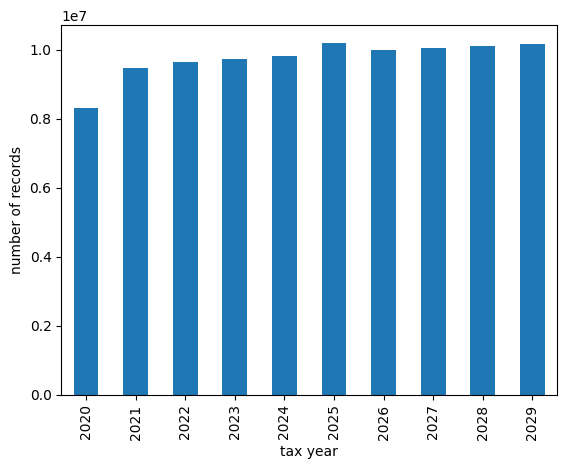

In [16]:
df_w2.tax_year.value_counts(sort=False).plot.bar()
plt.xlabel('tax year')
plt.ylabel('number of records')

# Plot number of records by year again, but split into W2s and 1099s

I've never made a stacked bar chart before, so I'm experimenting a bit...

In [81]:
%time temp = df_w2.value_counts(['tax_year', 'is_w2'], sort=False)
# The following groupby is equivalent to value_counts() - see below
# %time temp = df_w2.groupby(['tax_year', 'is_w2'])['ssn'].count()
temp

CPU times: user 2.89 s, sys: 1.65 s, total: 4.55 s
Wall time: 4.55 s


tax_year  is_w2
2020      False     446203
          True     7877366
2021      False     505780
          True     8951686
2022      False     515801
          True     9116721
2023      False     520306
          True     9224357
2024      False     526278
          True     9305747
2025      False     544645
          True     9662683
2026      False     533771
          True     9448472
2027      False     537755
          True     9512085
2028      False     542506
          True     9570750
2029      False     544603
          True     9627708
dtype: int64

In [82]:
# .value_counts() is equivalent to doing a groupby
%time temp2 = df_w2.groupby(['tax_year', 'is_w2'])['ssn'].count()
temp2.equals(temp)

CPU times: user 2.73 s, sys: 1.6 s, total: 4.33 s
Wall time: 4.33 s


True

In [100]:
# Get separate Series for W2s and 1099s
w2_counts_by_year = temp.loc[:,True]
ten99_counts_by_year = temp.loc[:,False]
# Putting them in a dataframe is equivalent to calling .unstack('is_w2')
pd.concat({"W2's": w2_counts_by_year, "1099's": ten99_counts_by_year}, axis=1)

,W2's,1099's
tax_year,,
2020,7877366,446203
2021,8951686,505780
2022,9116721,515801
2023,9224357,520306
2024,9305747,526278
2025,9662683,544645
2026,9448472,533771
2027,9512085,537755
2028,9570750,542506


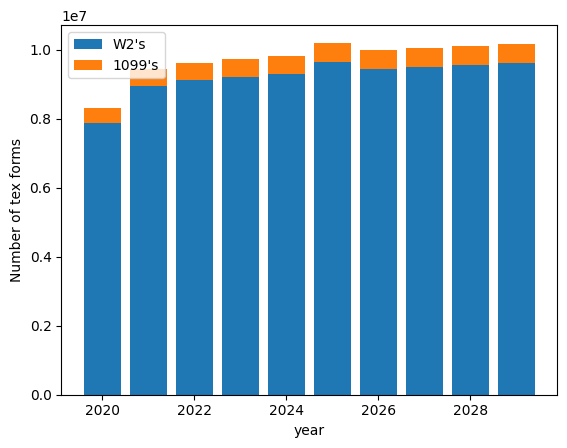

In [97]:
# Solution 1 for stacked bar chart from here:
# https://python-charts.com/part-whole/stacked-bar-chart-matplotlib/
plt.bar(w2_counts_by_year.index, w2_counts_by_year, label="W2's")
plt.bar(
    ten99_counts_by_year.index,
    ten99_counts_by_year,
    bottom=w2_counts_by_year,
    label="1099's"
)
plt.xlabel("year")
plt.ylabel("Number of tex forms")
plt.legend()

Text(0, 0.5, 'Number of tax forms')

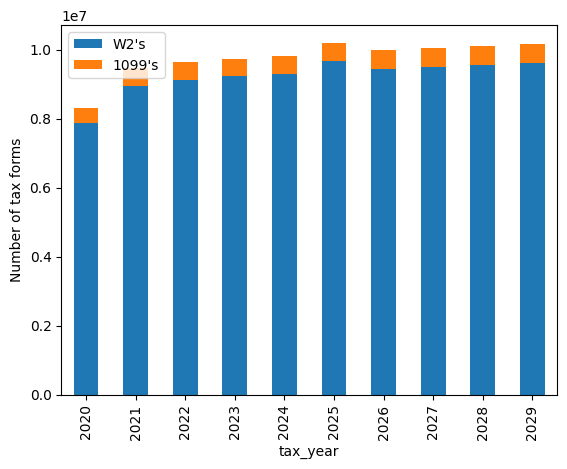

In [102]:
# Solution 2 for stacked bar chart from DataFrame.plot.bar() docstring
pd.concat(
    {"W2's": w2_counts_by_year, "1099's": ten99_counts_by_year},
    axis=1
).plot.bar(stacked=True)
# temp.unstack().plot.bar(stacked=True) # Similar but puts 1099s on bottom
plt.ylabel("Number of tax forms")

CPU times: user 2.83 s, sys: 1.62 s, total: 4.45 s
Wall time: 4.45 s


<AxesSubplot: xlabel='tax_year', ylabel='Number of tax forms'>

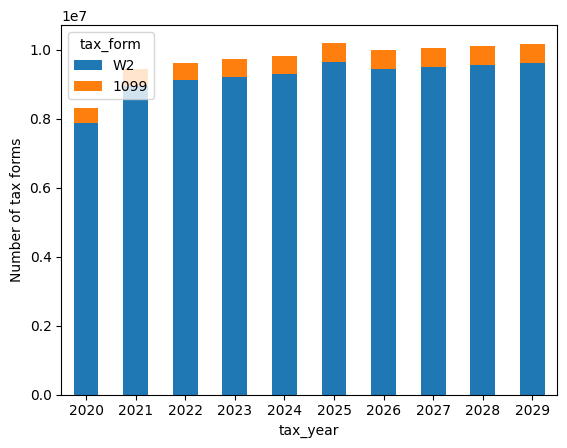

In [123]:
%%time

# Same solution as above, but create a DataFrame using .unstack(),
# enabling chaining all transformations together
tax_forms_by_year = (
    df_w2.value_counts(['tax_year', 'is_w2'], sort=False)
    .rename({True: "W2", False: "1099"}, level="is_w2")
    .rename_axis(index={"is_w2": "tax_form"})
    .unstack("tax_form")
    [["W2", "1099"]] # re-order the columns
)
tax_forms_by_year.plot.bar(stacked=True, rot=0, ylabel="Number of tax forms")

# What fraction of forms are 1099s?

About 5.7% each year. The documentation [says](https://vivarium-research.readthedocs.io/en/latest/models/concept_models/vivarium_census_synthdata/concept_model.html#id99) it should be 5.35%...

In [103]:
ten99_counts_by_year / w2_counts_by_year

tax_year
2020    0.056644
2021    0.056501
2022    0.056577
2023    0.056406
2024    0.056554
2025    0.056366
2026    0.056493
2027    0.056534
2028    0.056684
2029    0.056566
dtype: float64

# How many simulants?

There are 9_350_024 = 9.35 million simulants in the test data.

This run consisted of 10 seeds consisting of 1_000_000 people each, so 10 million people total.

So the W2/1099 data contains about 93.5% of the pooulation. That seems high if we're not supposed to have children in here...

But there are only 6_451_376 = 6.45 million simulants in 2020, so really only 64.5% of our initial population shows up in the data, which is more reasonable. The rest must be simulants who either turn 18 and start working during the sim, or immigrants who enter the sim and start working.

In [18]:
%time df_w2.simulant_id.nunique()

CPU times: user 4.89 s, sys: 228 ms, total: 5.12 s
Wall time: 5.12 s


9350024

In [19]:
9350024/1_000_000

9.350024

In [59]:
%time df_w2.query("tax_year == 2020").simulant_id.nunique()

CPU times: user 2.22 s, sys: 1.02 s, total: 3.24 s
Wall time: 3.24 s


6451376

In [60]:
%time temp = df_w2.groupby("tax_year").simulant_id.nunique()
temp

CPU times: user 19.5 s, sys: 1.75 s, total: 21.2 s
Wall time: 21.2 s


tax_year
2020    6451376
2021    6836750
2022    6970087
2023    7062391
2024    7137685
2025    7256586
2026    7263635
2027    7319022
2028    7370073
2029    7418122
Name: simulant_id, dtype: int64

Text(0, 0.5, 'Number of people with W2s or 1099s')

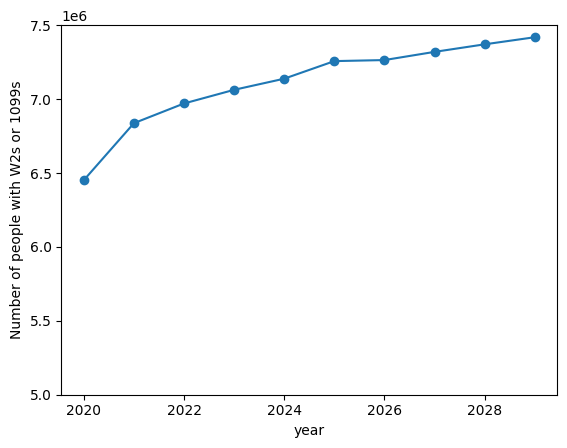

In [69]:
plt.plot(temp.index, temp, marker='o')
plt.ylim(5e6 ,7.5e6)
plt.xlabel('year')
plt.ylabel('Number of people with W2s or 1099s')

# Check overall age distribution

Looks reasonable. Minimum age is 18, and maximum is 108.

But why is there a bump around age 60 (and other, smaller weird bumps at younger ages)?

Note that this is counting _rows_ not simulants, so the same simulant will show up multiple times if they are employed in multiple years and/or have multiple jobs in one year. So the bump at 60 could be due to, e.g., more 60-year-olds being employed than 50-year-olds, or due to 60-year-olds having multiple jobs per year more frequently than 50-year-olds. Or something else I haven't thought of. We'll have to drill down farther into the data to figure it out.

CPU times: user 1.46 s, sys: 336 ms, total: 1.79 s
Wall time: 1.79 s


Text(0.5, 1.0, 'Age distribution of rows in all years combined (2020-2029)')

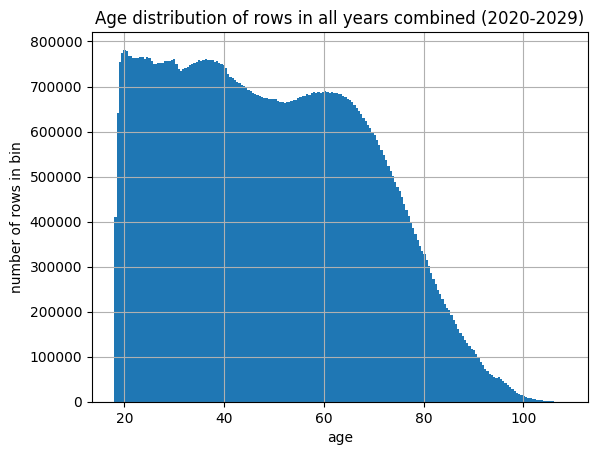

In [35]:
%time df_w2.age.hist(bins=200)
plt.xlabel('age')
plt.ylabel('number of rows in bin')
plt.title("Age distribution of rows in all years combined (2020-2029)")

In [23]:
df_w2.age.describe()

count    9.751522e+07
mean     4.917890e+01
std      1.915804e+01
min      1.800045e+01
25%      3.282000e+01
50%      4.797651e+01
75%      6.423642e+01
max      1.084132e+02
Name: age, dtype: float64

In [24]:
df_w2.age.min(), df_w2.age.max()

(18.000448, 108.41321)

CPU times: user 2.03 s, sys: 976 ms, total: 3 s
Wall time: 3 s


Text(0.5, 1.0, 'Age distribution of rows in 2020')

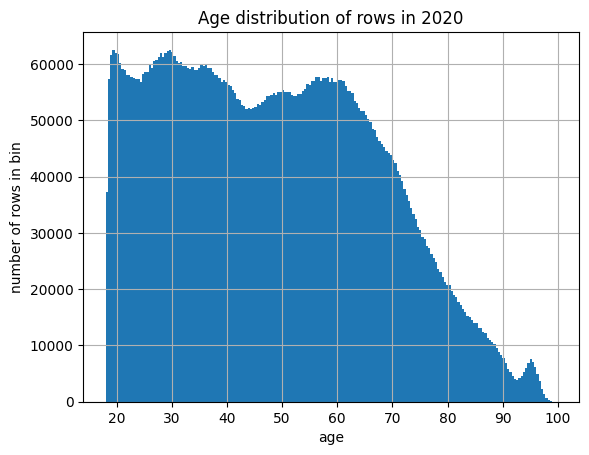

In [36]:
%time df_w2.query("tax_year==2020").age.hist(bins=200)
plt.xlabel('age')
plt.ylabel('number of rows in bin')
plt.title("Age distribution of rows in 2020")

# Plot overall age distribution of rows for each year

Nice, we can see the age distribution move to the right one year at a time, and the distribution gets less lumpy over time.

CPU times: user 18.9 s, sys: 9.78 s, total: 28.7 s
Wall time: 28.7 s


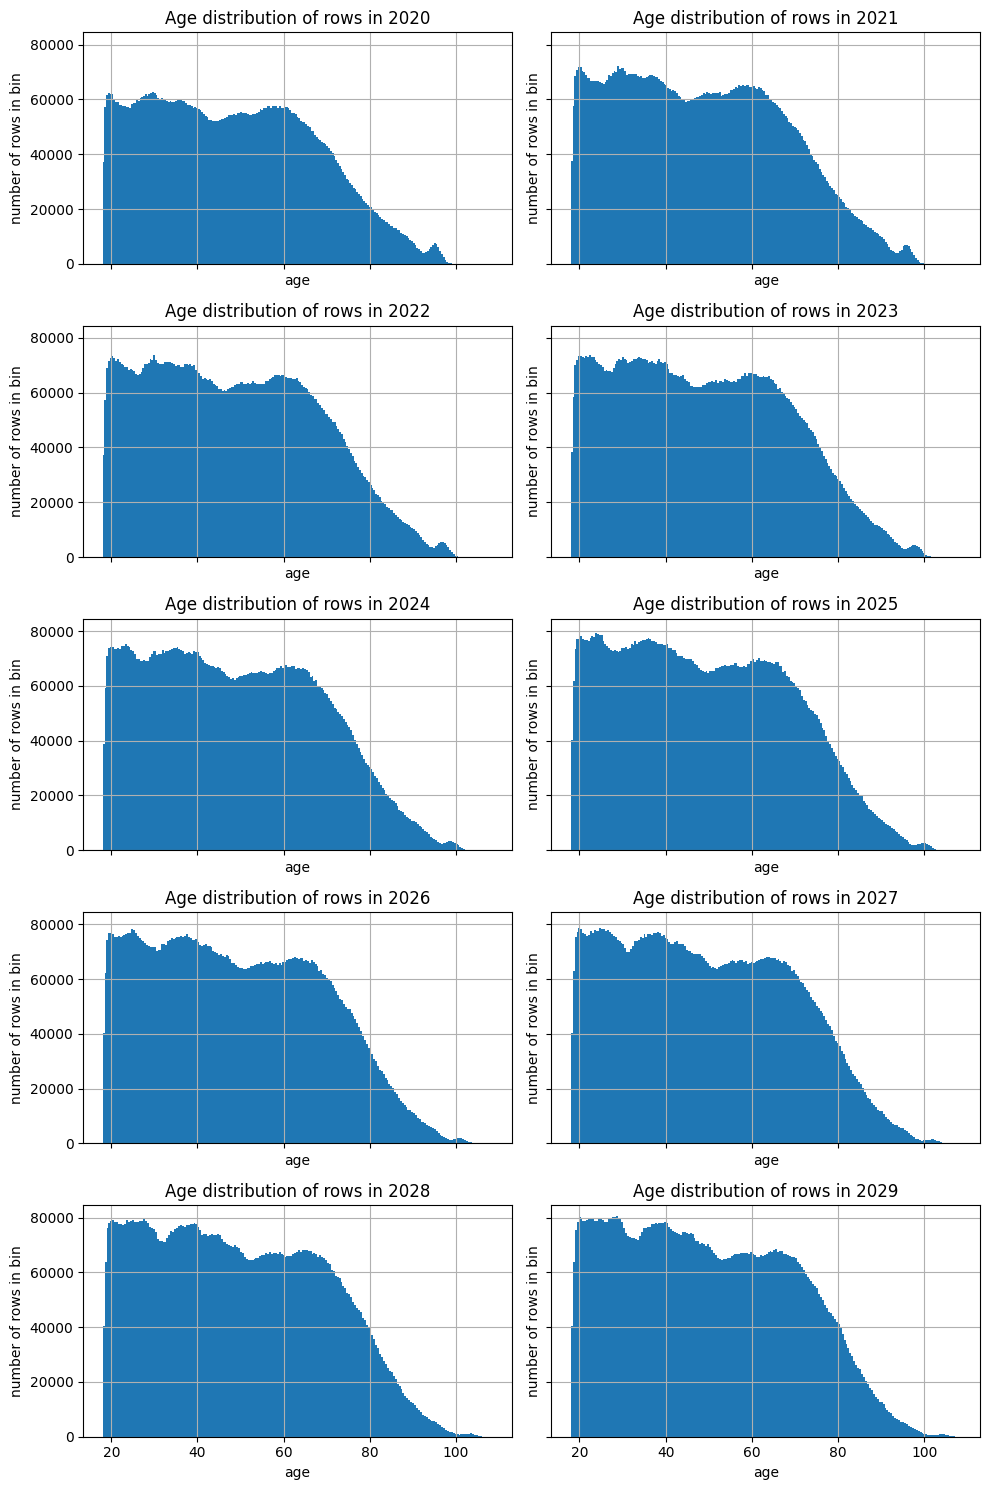

In [147]:
%%time
def plot_age_distribution_of_rows_for_year(df_w2, year, ax):
    df_w2.query("tax_year == @year").age.hist(bins=200, ax=ax)
    ax.set_xlabel('age')
    ax.set_ylabel('number of rows in bin')
    ax.set_title(f"Age distribution of rows in {year}")
#     ax.set_xticks(range(10, 120, 10))
#     ax.set_yticks(range(0, 100_000, 20_000))
    
fig, axs = plt.subplots(5, 2, figsize=(10,15), sharex=True, sharey=True)
for year, ax in zip(range(2020, 2030), axs.flatten()):
    plot_age_distribution_of_rows_for_year(df_w2, year, ax)
fig.tight_layout()

In [121]:
2**20/10**6 # MiB per MB

1.048576

# See how many forms people file each year

In [126]:
%%time
df_w2.value_counts(['tax_year', 'simulant_id'])

CPU times: user 32.9 s, sys: 6.46 s, total: 39.4 s
Wall time: 39.4 s


tax_year  simulant_id  
2025      4369000652186    8
          7359000343907    8
2023      3541000690304    8
2029      2284001127141    8
2024      5616000051151    8
                          ..
          2284000635690    1
          2284000635692    1
          2284000635693    1
          2284000635694    1
2029      7359001173279    1
Length: 71085727, dtype: int64

In [127]:
temp = _

In [133]:
temp.value_counts()

1    48908624
2    18378084
3     3380083
4      386412
5       30695
6        1749
7          75
8           5
dtype: int64

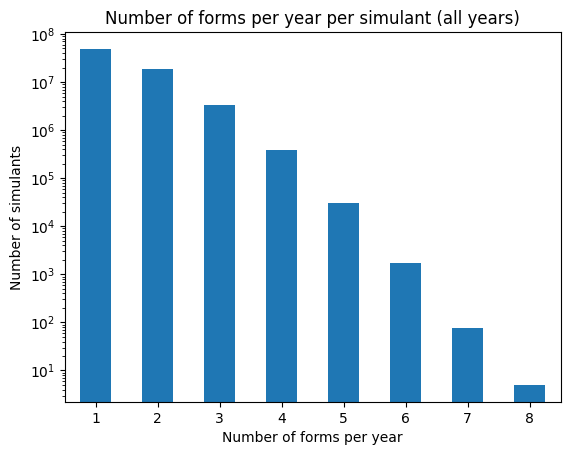

In [148]:
temp.value_counts().plot.bar(rot=0)
plt.xlabel('Number of forms per year')
plt.ylabel('Number of simulants')
plt.title("Number of forms per year per simulant (all years)")
plt.yscale('log')

In [139]:
df_forms_per_year = temp.rename('num_forms').reset_index('tax_year')
df_forms_per_year

,tax_year,num_forms
simulant_id,,
4369000652186,2025,8
7359000343907,2025,8
3541000690304,2023,8
2284001127141,2029,8
5616000051151,2024,8
...,...,...
2284000635690,2024,1
2284000635692,2024,1
2284000635693,2024,1


In [149]:
%%time
temp2 = df_forms_per_year.value_counts(['tax_year', 'num_forms'], sort=False)
temp2

CPU times: user 2.01 s, sys: 1.14 s, total: 3.14 s
Wall time: 3.14 s


tax_year  num_forms
2020      1            4813619
          2            1421703
          3             198575
          4              16601
          5                855
                        ...   
2029      4              40056
          5               3078
          6                173
          7                  7
          8                  1
Length: 74, dtype: int64

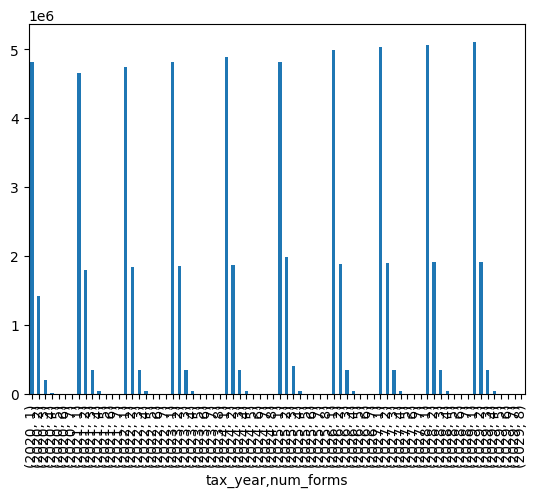

In [144]:
ax = temp2.plot.bar(colors=)

In [146]:
def plot_forms_per_year():
    temp.value_counts().plot.bar(rot=0)
    plt.xlabel('Number of forms per year')
    plt.ylabel('Number of simulants')
    plt.title("Number of forms per year per simulant (all years)")
    plt.yscale('log')


In [150]:
%%time
forms_per_year = df_w2.value_counts(['tax_year', 'is_w2', 'simulant_id'])
forms_per_year

CPU times: user 33 s, sys: 7.63 s, total: 40.7 s
Wall time: 40.7 s


tax_year  is_w2  simulant_id  
2024      True   5616000051151    8
2029      True   2284001127141    8
2025      True   7359000343907    8
                 4369000652186    8
2023      True   3541000690304    8
                                 ..
2024      True   2284000088149    1
                 2284000088152    1
                 2284000088153    1
                 2284000088154    1
2029      True   7359001173279    1
Length: 71085727, dtype: int64

In [151]:
# Why does the above have the same number of rows as when I didn't include 'is_w2'?????

# ( 71085727
#     forms_per_year
#     .rename()
# )

In [152]:
forms_per_year.index.unique('is_w2')

Index([True, False], dtype='bool', name='is_w2')

In [ ]:
# This killed my kernel...
forms_per_year.groupby(['tax_year', 'simulant_id']).sum()

In [1]:
temp

NameError: name 'temp' is not defined